# Panaroma Stitching and Stereo Matching
---

### Om Shri Prasath EE17B113

## Importing the required libraries

- Numpy - For matrix manipulations (mainly used in Non-Max Supression and Calculating Magnitude and Angle)
- Scipy - For convolutions
- Matplotlib - For displaying image
- OpenCV - For reading images from source

> _Note! Need to use python version `3.6.9` and install `opencv-contrib-python` for using SURF features_

In [1]:
# Installing opencv-contrib python
!python --version
!pip install opencv-python==3.4.2.16 opencv-contrib-python==3.4.2.16

Python 3.6.9
You are using pip version 18.1, however version 20.2.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Note : Used for autoformatting the notebook, remove if causing any error
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# Importing the required libraries

import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import itertools

# To remove unnecessary warnings
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

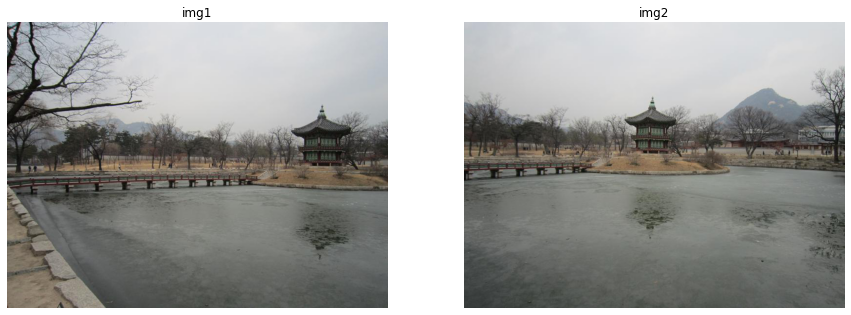

<IPython.core.display.Javascript object>

In [4]:
img1 = plt.imread("img1.jpg")
img2 = plt.imread("img2.jpg")


def plot_imgs(img1, img2, title="Images"):
    fig, ax = plt.subplots(1, 2, figsize=(15, 20))
    for a in ax:
        a.set_axis_off()
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    ax[0].set_title("img1")
    ax[1].set_title("img2")
    plt.show()


plot_imgs(img1, img2)

## Compute SURF Features and Match Keypoints

In [5]:
def get_surf_features(img):
    """
    Compute SURF features using cv2 library functions. Use default parameters when computing the keypoints.
    Input: 
      img: cv2 image
    Returns:
      keypoints: a list of cv2 keypoints
      descriptors: a list of SURF descriptors
    """

    surf = cv2.xfeatures2d.SURF_create()
    keypoints, descriptors = surf.detectAndCompute(img, None)

    return keypoints, descriptors


def match_keypoints(desc_1, desc_2, ratio=0.75):
    """
    You may use cv2 library functions.
    Input:
      desc_1, desc_2: list of feature descriptors
    Return:
      matches: list of feature matches
    """

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc_1, desc_2, k=2)

    matches_ratio = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            matches_ratio.append(m)

    return matches_ratio

<IPython.core.display.Javascript object>

					Keypoints for img1 and img2


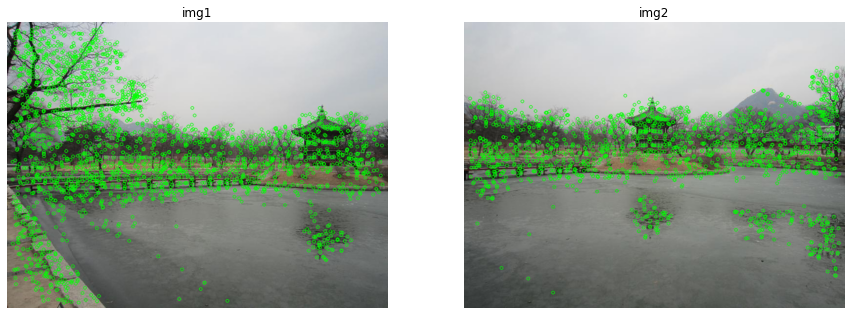

<IPython.core.display.Javascript object>

In [6]:
kp_1, desc_1 = get_surf_features(img1)
kp_2, desc_2 = get_surf_features(img2)

kp_img1 = cv2.drawKeypoints(img1, kp_1, None, color=(0, 255, 0), flags=0)
kp_img2 = cv2.drawKeypoints(img2, kp_2, None, color=(0, 255, 0), flags=0)

print("\t\t\t\t\tKeypoints for img1 and img2")
plot_imgs(kp_img1, kp_img2)

						surf feature matches


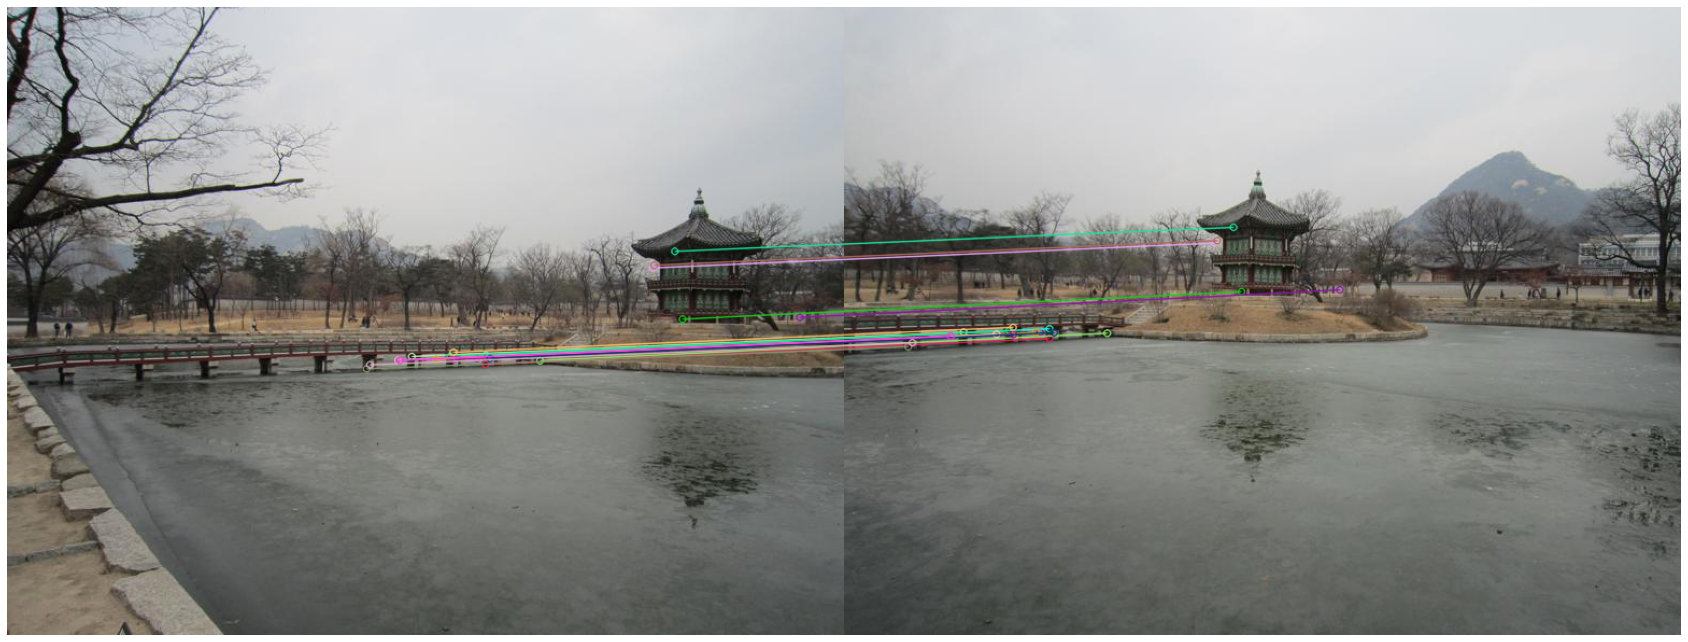

<IPython.core.display.Javascript object>

In [7]:
matches = match_keypoints(desc_1, desc_2)
match_plot = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:20], None, flags=2)
print("\t\t\t\t\t\tsurf feature matches")
plt.figure(figsize=(30, 15))
plt.imshow(match_plot)
plt.axis("off")
plt.show()

## Compute Homography Matrix using RANSAC

In [89]:
def find_homography(pts_1, pts_2):
    """
    Implement Direct Linear Transform to find a homography that estimates the transformation mapping from pts_1 to pts_2.
    e.g. If x is in pts_1 and y is in pts_2, then y = H * x
    Input:
      pts_1, pts_2: (N, 2) matrix 
    Return:
      H: the resultant homography matrix (3 x 3)
    """
    A = []
    for i in range(pts_1.shape[0]):
        xa, ya = pts_1[i]
        xb, yb = pts_2[i]
        A.append([-xa, -ya, -1, 0, 0, 0, xa * xb, ya * xb, xb])
        A.append([0, 0, 0, -xa, -ya, -1, xa * yb, ya * yb, yb])

    A = np.array(A)

    U, S, V = np.linalg.svd(A)

    L = V[-1, :]

    H = L.reshape(3, 3)

    return H

<IPython.core.display.Javascript object>

In [97]:
def transform_ransac(pts_1, pts_2):
    """
    Implement RANSAC to estimate homography matrix.
    Input:
      pts_1, pts_1: (N, 2) matrices
    Return:
      best_model: homography matrix with most inliers
    """
    pts_2_hmg = np.c_[pts_2, np.ones(pts_2.shape[0])]

    vals = []

    best_model = np.zeros((3, 3))
    best_inliers_1 = []
    best_inliers_2 = []

    threshold = 1
    for i in range(2000):
        inliers = []
        indices = random.sample(range(1, len(pts_1)), 4)
        model = find_homography(pts_2[indices, :], pts_1[indices, :])

        pts_1_hmg_pred = np.matmul(pts_2_hmg, model.T)
        pts_1_pred = np.c_[
            pts_1_hmg_pred[:, 0] / pts_1_hmg_pred[:, 2],
            pts_1_hmg_pred[:, 1] / pts_1_hmg_pred[:, 2],
        ]
        inlier_indices = np.sum((pts_1 - pts_1_pred) ** 2, axis=1) < threshold
        inliers_1 = pts_2[inlier_indices]
        inliers_2 = pts_2[inlier_indices]
        if len(best_inliers_1) < len(inliers_1):
            best_model = model
            best_inliers_1 = inliers_1
            best_inliers_2 = inliers_2

    return best_model

<IPython.core.display.Javascript object>

In [166]:
def panoramic_stitching(img1, img2):
    """
    Generate a panoramic image using the obtained homography matrix.
    Input: 
      img1, img2: cv2 images
    Return:
      final_img: cv2 image of panorama
    """
    kp_1, desc_1 = get_surf_features(img1)
    kp_2, desc_2 = get_surf_features(img2)

    matches = match_keypoints(desc_1, desc_2)

    pts_1 = []
    pts_2 = []

    for match in matches:
        img1_idx = match.queryIdx
        img2_idx = match.trainIdx

        pts_1.append(np.array(kp_1[img1_idx].pt))
        pts_2.append(np.array(kp_2[img2_idx].pt))

    pts_1 = np.array(pts_1)
    pts_2 = np.array(pts_2)

    model = transform_ransac(pts_1, pts_2)

    height, width, dim = img2.shape

    x, y = np.mgrid[:width, :height]

    l = len(x.reshape(-1, 1))

    src = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1), np.ones((l, 1))])
    src_indices = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)]).astype(int)

    dst = np.matmul(src, model.T)
    dst_indices = np.round(
        np.c_[dst[:, 0] / dst[:, 2], dst[:, 1] / dst[:, 2]], 0
    ).astype(int)

    final_img = np.zeros((dst_indices[:, 1].max(), dst_indices[:, 0].max(), dim))
    final_img[src_indices[:, 1], src_indices[:, 0]] = img1[
        src_indices[:, 1], src_indices[:, 0]
    ]

    model_inv = np.linalg.inv(model)

    height_new, width_new, dim_new = final_img.shape

    x, y = np.mgrid[:width_new, :height_new]

    l = len(x.reshape(-1, 1))

    dst = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1), np.ones((l, 1))])
    dst_indices = np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)]).astype(int)

    src = np.matmul(dst, model_inv.T)

    src_indices = np.round(
        np.c_[src[:, 0] / src[:, 2], src[:, 1] / src[:, 2]], 0
    ).astype(int)

    src_fin = src_indices[
        (src_indices[:, 0] >= 0)
        & (src_indices[:, 0] < img2.shape[1])
        & (src_indices[:, 1] >= 0)
        & (src_indices[:, 1] < img2.shape[0])
    ]
    dst_fin = dst_indices[
        (src_indices[:, 0] >= 0)
        & (src_indices[:, 0] < img2.shape[1])
        & (src_indices[:, 1] >= 0)
        & (src_indices[:, 1] < img2.shape[0])
    ]

    final_img[dst_fin[:, 1], dst_fin[:, 0]] = img2[src_fin[:, 1], src_fin[:, 0]]

    final_img = final_img.astype(np.uint8)

    return final_img

<IPython.core.display.Javascript object>

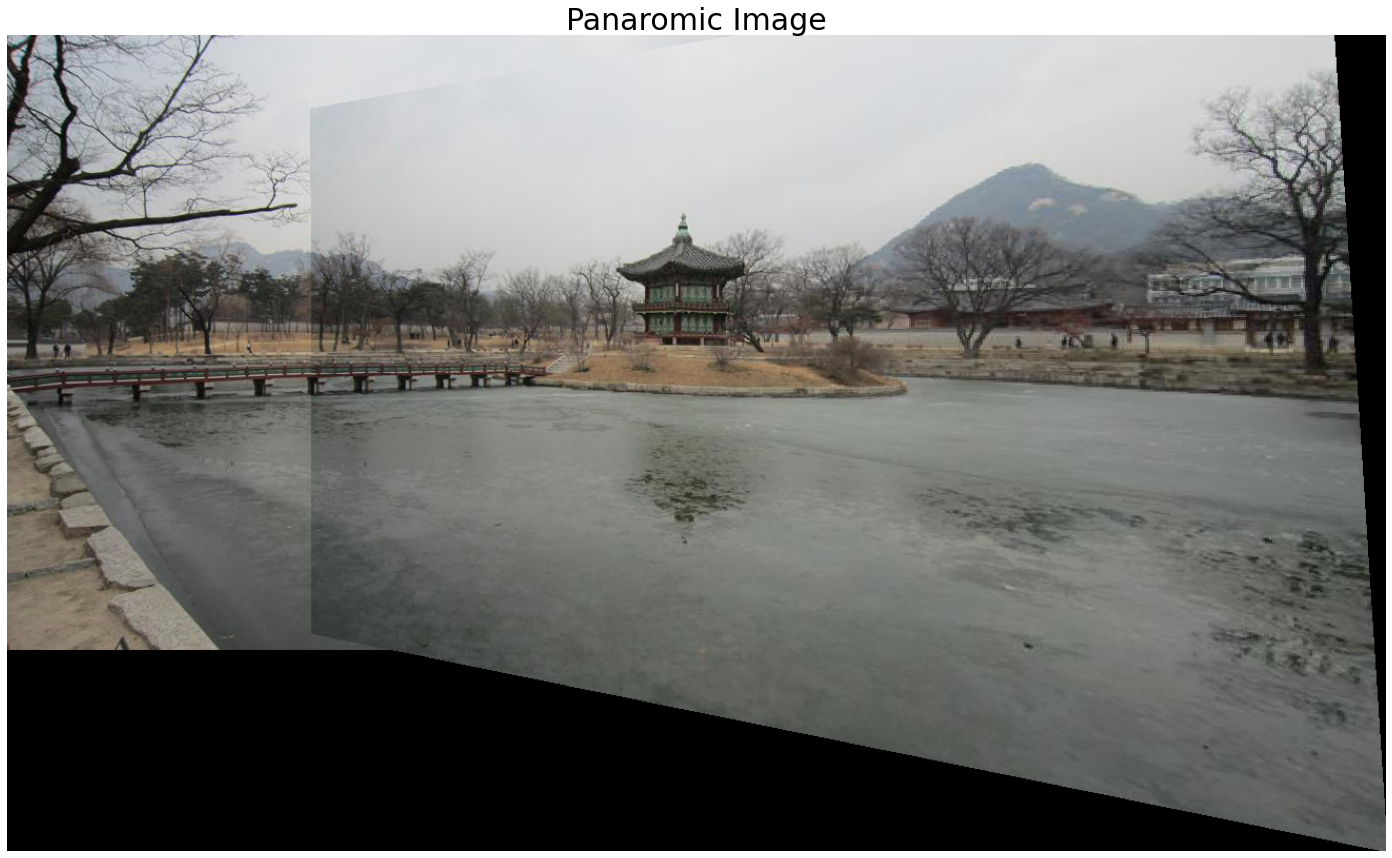

<IPython.core.display.Javascript object>

In [168]:
result = panoramic_stitching(img1, img2)
plt.figure(figsize=(30, 15))
plt.axis("off")
plt.title("Panaromic Image", fontsize=30)

plt.imshow(result)
plt.show()

## Panaroma with more than two images